In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
file = 'global_data_4_1'
time_bins = np.arange(0,24,float(file.split('_')[-1]))
H_bins = np.arange(90,130,float(file.split('_')[-2]))

shape = len(time_bins) * len(H_bins)

file_path = f'../../Output/{file}.csv'

In [26]:
data_df = pd.read_csv(file_path,low_memory=False)
exp_data_points = np.array(data_df['Experimental Data Points']).reshape(-1,shape)
model_data_points = np.array(data_df['Model Data Points']).reshape(-1,shape)
height = np.array(data_df['Height'])
hours = np.array(data_df['Hours'])
Svalbard = np.array(data_df ['Svalbard']).reshape(-1,shape)[:,0] == 1
Tromso = np.array(data_df['Tromso']).reshape(-1,shape)[:,0] == 1
Geomagnetic_Event = np.array(data_df['Geomagnetic Event']).reshape(-1,shape)[:,0] == 1
Solar_Proton_Event = np.array(data_df['Solar Proton Event']).reshape(-1,shape)[:,0] == 1

mask, type = np.repeat(True, len(exp_data_points)), 'all'
mask, type = Svalbard, 'Svalbard'
mask, type = Tromso, 'Tromso'
mask, type = Geomagnetic_Event, 'geo'
mask, type = Solar_Proton_Event, 'sol'
mask, type = (~Geomagnetic_Event) * (~Solar_Proton_Event), 'quiet'
mask, type = (Geomagnetic_Event) + (Solar_Proton_Event), 'active'

exp_data_points = exp_data_points[mask]
model_data_points = model_data_points[mask]

exp_data_points = exp_data_points.reshape(-1)
model_data_points = model_data_points.reshape(-1)

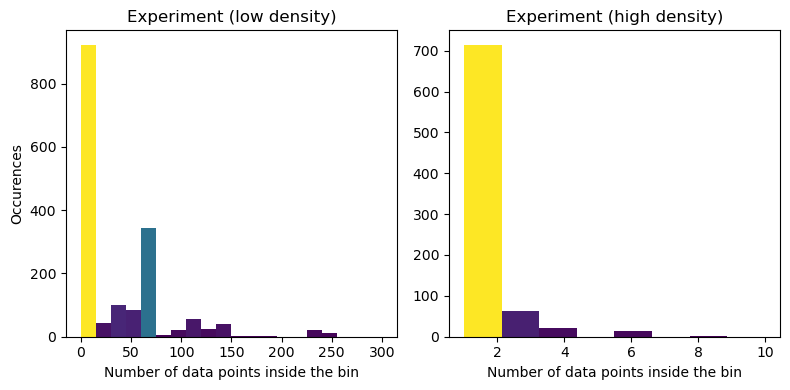

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

bins1 = np.linspace(0,300,21)
bins2 = np.linspace(1,10,9)
bins3 = np.linspace(500,2000,21)

N, bins, patches = axs[0].hist(exp_data_points, bins=bins1)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[1].hist(exp_data_points, bins=bins3)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[2].hist(model_data_points,  bins=bins2)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[0].set_title('Experiment (low density)')
axs[0].set_ylabel('Occurences')
axs[0].set_xlabel('Number of data points inside the bin')
axs[1].set_title('Experiment (high density)')
axs[1].set_xlabel('Number of data points inside the bin')
axs[2].set_title('Model')
axs[2].set_xlabel('Number of data points inside the bin')


plt.tight_layout()
#fig.suptitle('Data point repartition - 10 km-1 hour bin')
plt.savefig(f'../../Output/Figures/{type}/Data-Point-Repartition.png')
plt.show()

In [27]:
print(f'Experiment Data points: {int(sum(exp_data_points))}  -  Model Data Points: {int(sum(model_data_points))}')

unique_exp_dp, counts_exp = np.unique(exp_data_points, return_counts=True)
unique_model_dp, counts_model = np.unique(model_data_points, return_counts=True)

exp_dp_sum = []
model_dp_sum = []

for i in range(len(unique_exp_dp)):
    exp_dp_sum.append(np.sum(unique_exp_dp[:i+1] * counts_exp[0:i+1])/np.sum(exp_data_points))

for i in range(len(unique_model_dp)):
    model_dp_sum.append(np.sum(unique_model_dp[:i+1] * counts_model[0:i+1])/np.sum(model_data_points))

Experiment Data points: 142113  -  Model Data Points: 3214


[72.0, 144.0, 230.0, 239.0]
[2.0, 3.0, 4.0, 6.0]


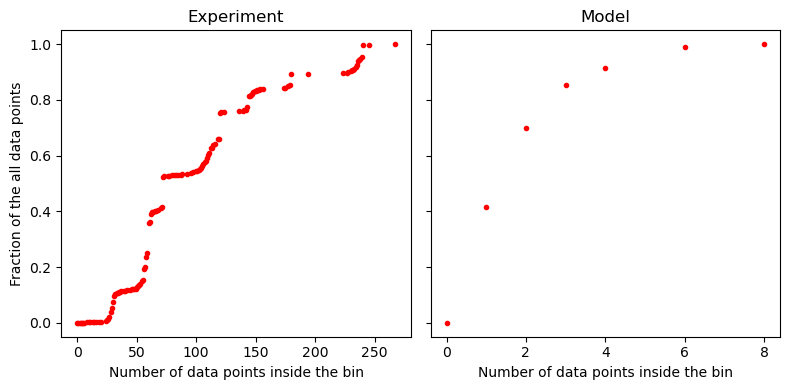

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

def find_density_percent(values, sum, percents):
    percents_return = []
    for percent in percents:
        percents_return.append(values[np.array(sum) > percent/100][0])
    return percents_return

print(find_density_percent(unique_exp_dp, exp_dp_sum, [50,80,90,95]))
print(find_density_percent(unique_model_dp, model_dp_sum, [50,80,90,95]))


axs[0].scatter(unique_exp_dp, exp_dp_sum,c='red', marker='.')
axs[0].set_ylabel('Fraction of the all data points')
axs[0].set_xlabel('Number of data points inside the bin')
axs[0].set_title('Experiment')
axs[1].scatter(unique_model_dp,model_dp_sum, label='Raw Data', c='red', marker='.')
axs[1].set_xlabel('Number of data points inside the bin')
axs[1].set_title('Model')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/Data-Point-Sum.png')
plt.show()

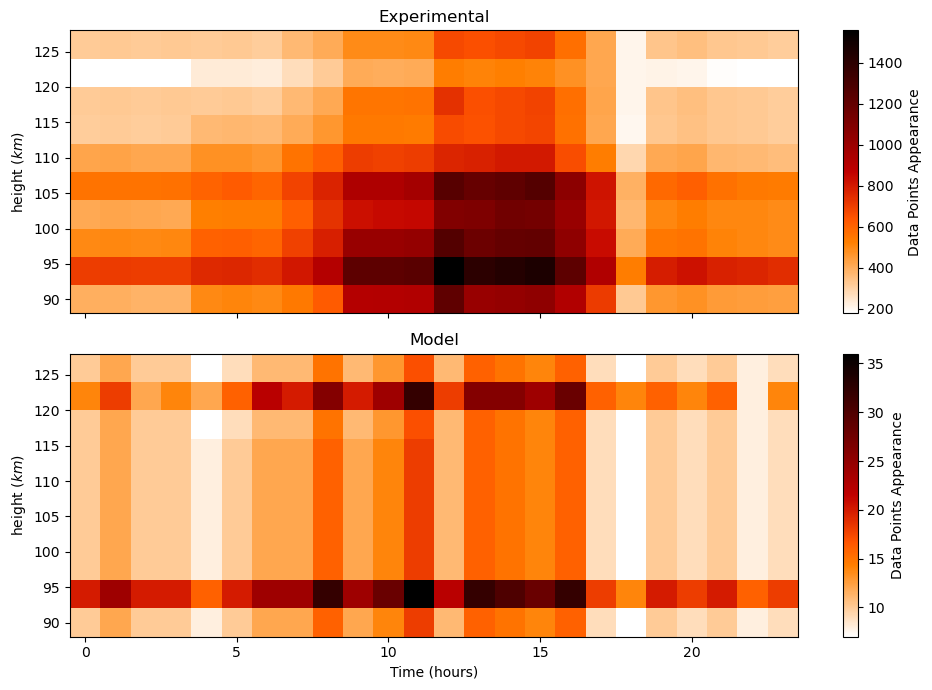

In [40]:
exp_grid = np.sum(exp_data_points.reshape(-1, shape), axis=0).reshape(len(H_bins), len(time_bins))
model_grid = np.sum(model_data_points.reshape(-1, shape), axis=0).reshape(len(H_bins), len(time_bins))

X, Y = np.meshgrid(time_bins, H_bins)

fig, axs = plt.subplots(2, figsize=(10,7), sharex = True)

mesh = axs[0].pcolormesh(X, Y, exp_grid, cmap = 'gist_heat_r')
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label("Data Points Appearance")
axs[0].set_title('Experimental')
axs[0].set_ylabel(r'height ($km$)')
mesh = axs[1].pcolormesh(X, Y, model_grid, cmap = 'gist_heat_r')
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label("Data Points Appearance")
axs[1].set_title('Model')
axs[1].set_xlabel(r'Time (hours)')
axs[1].set_ylabel(r'height ($km$)')
plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/Data-Point-Density-Sum.png')
plt.show()

In [41]:
counts_exp_dp = np.sum(np.sum(exp_data_points.reshape(-1, shape), axis=0).reshape(len(H_bins), len(time_bins)), axis = 1)
counts_model_dp = np.sum(np.sum(model_data_points.reshape(-1, shape), axis=0).reshape(len(H_bins), len(time_bins)), axis = 1)

exp_hist = [a for a, b in zip(H_bins.astype(int), counts_exp_dp.astype(int)) for _ in range(b)]
model_hist = [a for a, b in zip(H_bins.astype(int), counts_model_dp.astype(int)) for _ in range(b)]

counts_exp_dp_sum = [np.sum(counts_exp_dp[:i+1])/np.sum(counts_exp_dp) for i in range(len(H_bins))]
counts_model_dp_sum = [np.sum(counts_model_dp[:i+1])/np.sum(counts_model_dp) for i in range(len(H_bins))]

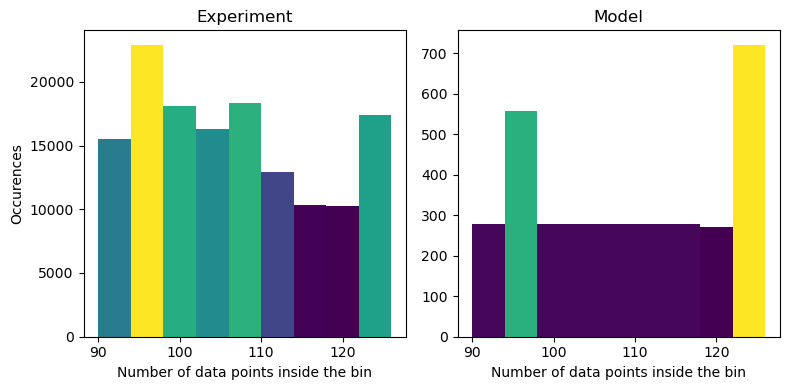

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

N, bins, patches = axs[0].hist(exp_hist, bins=H_bins)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[1].hist(model_hist, bins=H_bins)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[0].set_title('Experiment')
axs[0].set_ylabel('Occurences')
axs[0].set_xlabel('Number of data points inside the bin')
axs[1].set_title('Model')
axs[1].set_xlabel('Number of data points inside the bin')


plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/Data-Point-Repartition-Height.png')
plt.show()

[102, 114, 122, 126]
[106, 122, 122, 126]


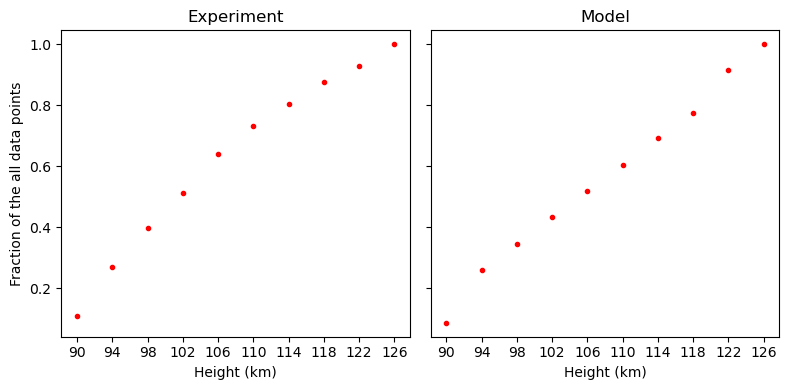

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

def find_height_percent(values, sum, percents):
    percents_return = []
    for percent in percents:
        percents_return.append(int(values[np.array(sum) > percent/100][0]))
    return percents_return

print(find_height_percent(H_bins, counts_exp_dp_sum, [50,80,90,95]))
print(find_height_percent(H_bins, counts_model_dp_sum, [50,80,90,95]))


axs[0].scatter(H_bins, counts_exp_dp_sum,c='red', marker='.')
axs[0].set_ylabel('Fraction of the all data points')
axs[0].set_xlabel('Height (km)')
axs[0].set_xticks(H_bins)
axs[0].set_title('Experiment')
axs[1].scatter(H_bins,counts_model_dp_sum, c='red', marker='.')
axs[1].set_xlabel('Height (km)')
axs[1].set_xticks(H_bins)
axs[1].set_title('Model')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/{type}/Data-Point-Sum-Height.png')
plt.show()